In [1]:
pip install openbb -q


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.4 MB/s eta 0:00:00a 0:00:01
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
Using cached pillow-11.2.1-cp39-cp39-macosx_11_0_arm64.whl

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openbb import obb

/Users/Sugi/Downloads/SoS-25-Algorithmic-Trading/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
obb.user.credentials.fmp_api_key = "JI198J9ADpdcD2yJ4kd8Zl0RAP1goenk"
symbols = ['AAPL', 'GOOG', 'MSFT', 'NVDA']
start_date = '2024-01-01'
initial_capital = 10000
short_window = 40
long_window = 100
dataframes = []

for symbol in symbols:
    try:
        data = obb.equity.price.historical(
            symbol=symbol,
            start_date=start_date,
            provider="fmp"
        ).to_df()
        data['Symbol'] = symbol
        dataframes.append(data)
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {str(e)}")

combined_data = pd.concat(dataframes)
combined_data = combined_data.reset_index()

combined_data.head()

,date,open,high,low,close,volume,vwap,adj_close,unadjusted_volume,change,change_percent,Symbol
0,2024-01-02,187.15,188.44,183.89,185.64,82488700,186.2800,184.29,82488700.0,-1.51,-0.008068,AAPL
1,2024-01-03,184.22,185.88,183.43,184.25,58414500,184.4450,182.91,58414500.0,0.03,0.000163,AAPL
2,2024-01-04,182.15,183.09,180.88,181.91,71983600,182.0075,180.59,71983600.0,-0.24,-0.001318,AAPL
3,2024-01-05,181.99,182.76,180.17,181.18,62379661,181.5250,179.86,62379661.0,-0.81,-0.004451,AAPL
4,2024-01-08,182.09,185.60,181.50,185.56,59144500,183.6875,184.21,59144500.0,3.47,0.019100,AAPL


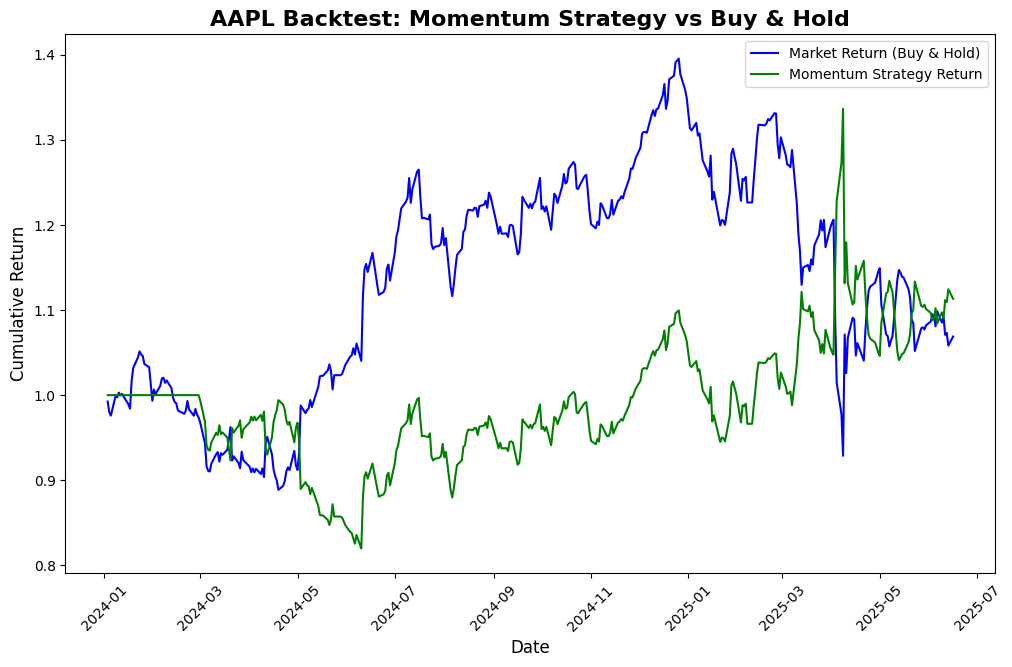

Final portfolio value for AAPL: $11131.92
Total market return for AAPL: 6.88%
Total strategy return for AAPL: 11.32%


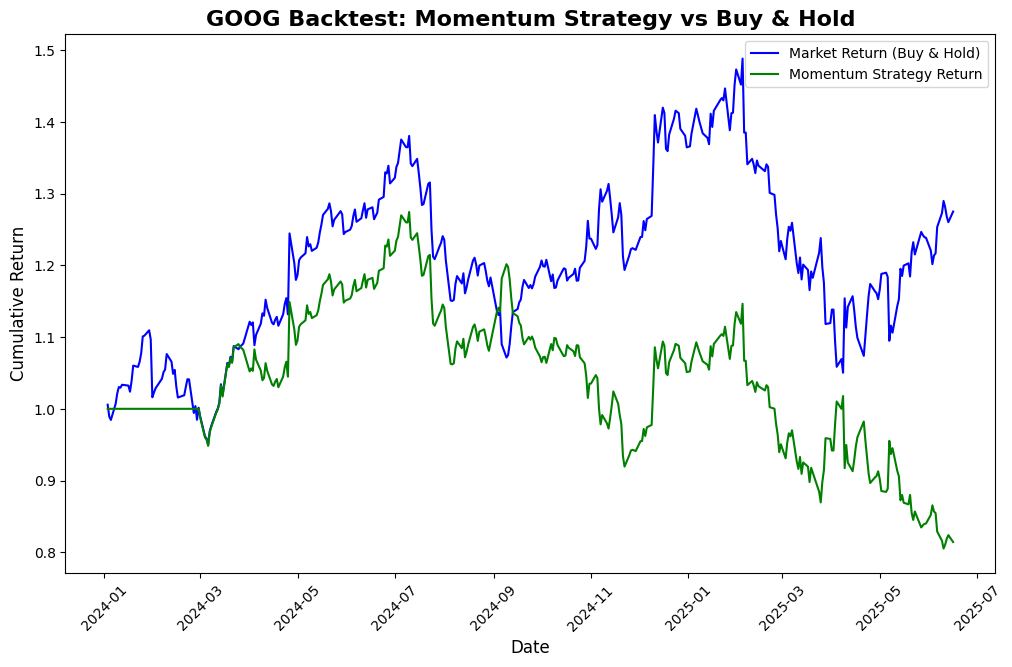

Final portfolio value for GOOG: $8142.44
Total market return for GOOG: 27.50%
Total strategy return for GOOG: -18.58%


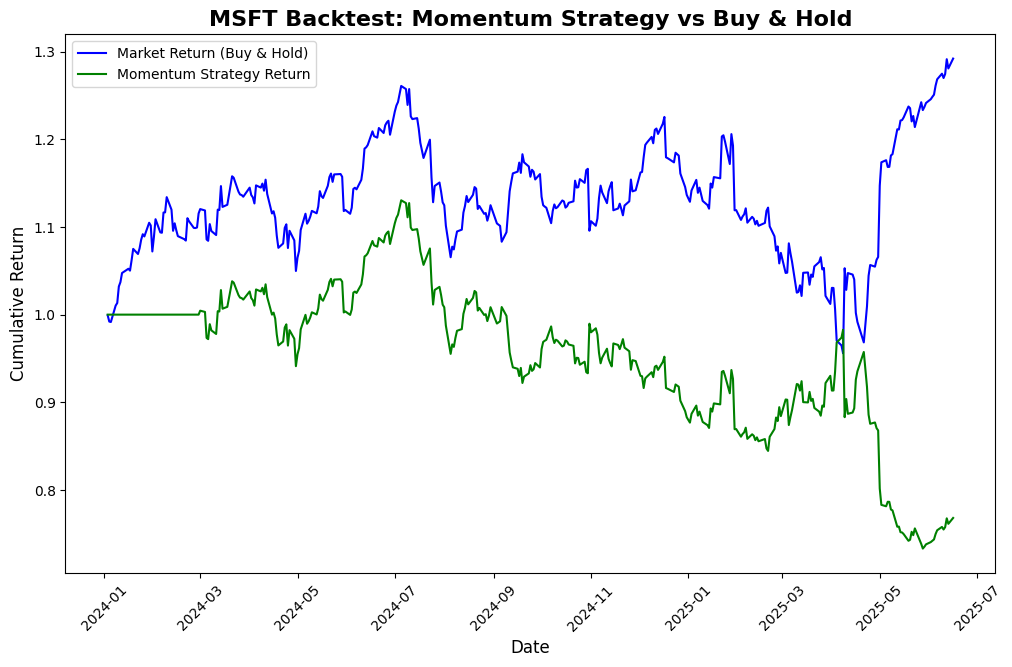

Final portfolio value for MSFT: $7681.91
Total market return for MSFT: 29.19%
Total strategy return for MSFT: -23.18%


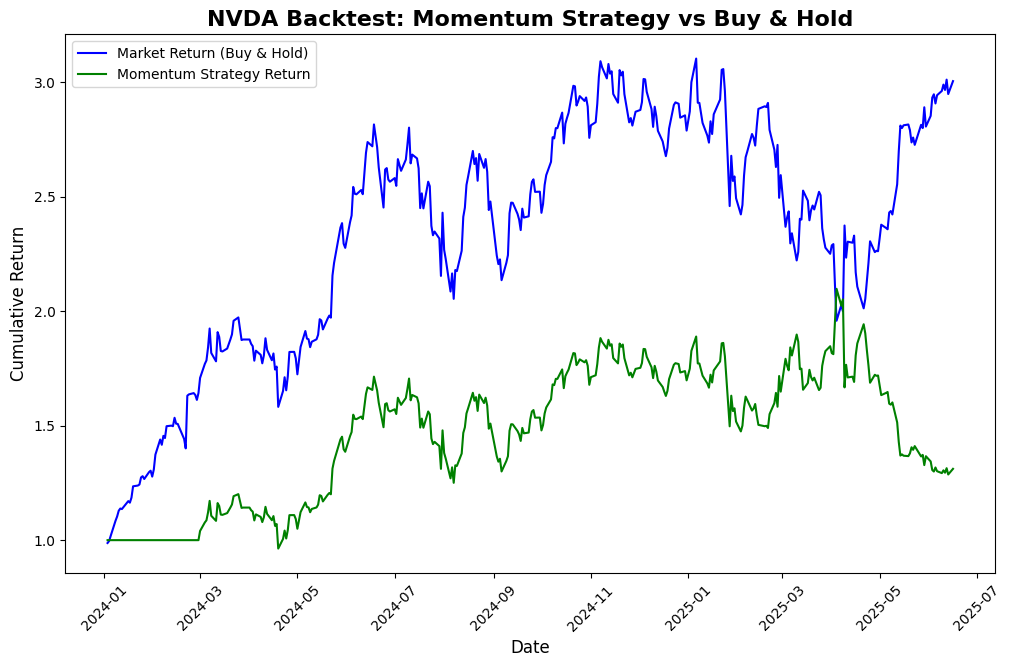

Final portfolio value for NVDA: $13113.06
Total market return for NVDA: 200.37%
Total strategy return for NVDA: 31.13%


In [9]:
def momentum_strategy(data, short_window, long_window):
    data['Short MA'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['Long MA'] = data['close'].rolling(window=long_window, min_periods=1).mean()

    data['Signal'] = 0
    signal_values = np.where(
        data['Short MA'][short_window:] > data['Long MA'][short_window:], 1, -1
    )
    data.loc[data.index[short_window:], 'Signal'] = signal_values
    data['Position'] = data['Signal'].shift(1)

    return data

def backtest(data, initial_capital):
    data['Daily Return'] = data['close'].pct_change()
    data['Strategy Return'] = data['Position'] * data['Daily Return']
    data['Cumulative Market Return'] = (1 + data['Daily Return']).cumprod()
    data['Cumulative Strategy Return'] = (1 + data['Strategy Return']).cumprod()
    data['Portfolio Value'] = initial_capital * data['Cumulative Strategy Return']

    return data

def visualize_backtest(data, symbol):
    plt.figure(figsize=(12, 7))

    plt.plot(data['date'], data['Cumulative Market Return'], label='Market Return (Buy & Hold)', color='blue')
    plt.plot(data['date'], data['Cumulative Strategy Return'], label='Momentum Strategy Return', color='green')

    plt.title(f'{symbol} Backtest: Momentum Strategy vs Buy & Hold', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.xticks(rotation=45)

    plt.legend()
    plt.show()

for symbol in symbols:
    stock_data = combined_data[combined_data['Symbol'] == symbol].copy()

    stock_data = momentum_strategy(stock_data, short_window, long_window)
    stock_data = backtest(stock_data, initial_capital)

    visualize_backtest(stock_data, symbol)

    final_portfolio_value = stock_data['Portfolio Value'].iloc[-1]
    print(f"Final portfolio value for {symbol}: ${final_portfolio_value:.2f}")

    total_market_return = stock_data['Cumulative Market Return'].iloc[-1] - 1
    total_strategy_return = stock_data['Cumulative Strategy Return'].iloc[-1] - 1
    print(f"Total market return for {symbol}: {total_market_return * 100:.2f}%")
    print(f"Total strategy return for {symbol}: {total_strategy_return * 100:.2f}%")
    print("="*40)